# Self-Driving Car Engineer 

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [1]:
# Libraries:
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import math
%matplotlib inline
import numpy as np
from collections import Counter
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import cv2
from sklearn.cross_validation import train_test_split
import pandas as pd

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Download the dataset

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/train.p',
            'train.p',
            pbar.hook)

if not isfile('test.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Test Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/test.p',
            'test.p',
            pbar.hook)

print('Training and Test data downloaded.')

Training and Test data downloaded.


In [3]:
# Load pickled data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
train_features, train_labels = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**



In [5]:
n_train = len(train_features)
n_test = len(X_test)
image_shape = X_test[0].shape
n_classes = len(set(train_labels))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [7]:
data_test = [[i,sum(y_test == i)] for i in range(len(np.unique(y_test)))]
data_test_sorted = sorted(data_test, key=lambda x: x[1])
data_train = [[i,sum(train_labels == i)] for i in range(len(np.unique(train_labels)))]
data_train_sorted = sorted(data_train, key=lambda x: x[1])
data_pd = pd.read_csv('signnames.csv')
data_pd['Occurance (Train)'] = pd.Series(np.asarray(data_train_sorted).T[1], index=np.asarray(data_train_sorted).T[0])
data_pd['Occurance (Test)'] = pd.Series(np.asarray(data_test_sorted).T[1], index=np.asarray(data_test_sorted).T[0])

data_pd_sorted = data_pd.sort_values(['Occurance (Train)'],ascending=[0]).reset_index()
data_pd_sorted = data_pd_sorted.drop('index', 1)

In [8]:
data_pd_sorted.head()

,ClassId,SignName,Occurance (Train),Occurance (Test)
0,2,Speed limit (50km/h),2250,750
1,1,Speed limit (30km/h),2220,720
2,13,Yield,2160,720
3,12,Priority road,2100,690
4,38,Keep right,2070,690


In [9]:
data_pd_sorted.tail()

,ClassId,SignName,Occurance (Train),Occurance (Test)
38,32,End of all speed and passing limits,240,60
39,27,Pedestrians,240,60
40,37,Go straight or left,210,60
41,19,Dangerous curve to the left,210,60
42,0,Speed limit (20km/h),210,60


### Visualization of the dataset

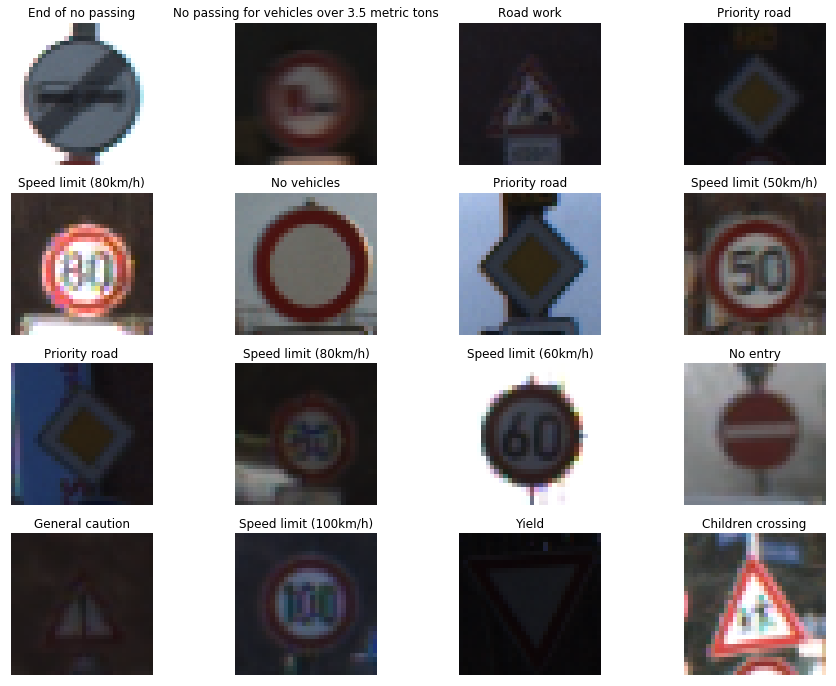

In [11]:
def showGrid(X,Y):
    plt.figure(figsize = (16,12))
    gs1 = gridspec.GridSpec(4,4)
    gs1.update(wspace=0.02, hspace=0.2) # set the spacing between axes. 
    for i in range(16):
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(Y))
        plt.imshow(X[ind_plot])
        sign_number=(Y[ind_plot])
        plt.title(data_pd.iloc[sign_number].SignName)
        plt.axis('off')
    plt.show()
    

showGrid(train_features,train_labels)

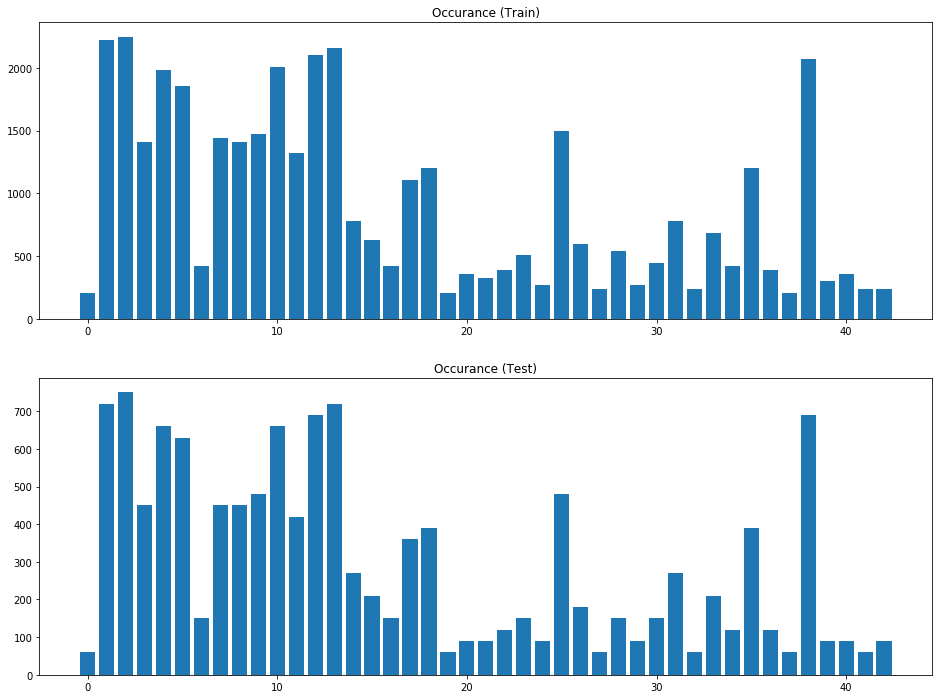

In [14]:
plt.figure(figsize=(16,12))
plt.subplot(212)
plt.bar(range(43),height=data_pd["Occurance (Test)"])
plt.title("Occurance (Test)")

plt.subplot(211)
plt.bar(range(43),height=data_pd["Occurance (Train)"])
plt.title("Occurance (Train)")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implementation of a deep learning model that learns to recognize traffic signs. Trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 


### Pre-process the Data Set 

In [15]:
%%time

#Random bright

new=[]
for feature in train_features:
    #feature = cv2.cvtColor(feature, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    #feature[:,:,0] = cv2.equalizeHist(feature[:,:,0])
    # convert the YUV image back to RGB format
    #feature = cv2.cvtColor(feature, cv2.COLOR_YUV2BGR)
    rnd_number=np.random.uniform()
    image1 = cv2.cvtColor(feature,cv2.COLOR_RGB2HSV)
    random_bright = .25+rnd_number
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    new.append(image1)
train_features=np.concatenate((train_features,new),axis=0)
print(len(train_labels))
train_labels=np.concatenate((train_labels,train_labels),axis=0)
print(len(train_labels))


39209
78418
CPU times: user 2.12 s, sys: 132 ms, total: 2.26 s
Wall time: 2.25 s


In [17]:
X_train=train_features
y_train=train_labels

In [18]:
# Normalize between -1 and 1
X_train=np.array(X_train)
X_train = X_train.astype('float32')
X_train = (X_train - 128.) / 128.
X_test = X_test.astype('float32')
X_test  = (X_test  - 128.) / 128.

In [19]:
X_train, y_train = shuffle(X_train, y_train)
print("Data shuffled")
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.15)
print("Validation ready")

Data shuffled
Validation ready


### Model Architecture

In [20]:
EPOCHS = 1000
BATCH_SIZE = 124
LEARNING_RATE= .001
BETA=1e-5
DROPOUT_KEEP=.5

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [21]:
def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # L2 Regularization
    l2_loss= (tf.nn.l2_loss(conv1_W)+tf.nn.l2_loss(conv2_W)+tf.nn.l2_loss(fc2_W)+tf.nn.l2_loss(fc1_W)+tf.nn.l2_loss(fc3_W))
    
    return logits,l2_loss

In [22]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [23]:
logits,l2 = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)+BETA*l2
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [24]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [25]:
%%time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:DROPOUT_KEEP})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        if (i+1)%5==0:
            if (i+1)%50==0:
                saver.save(sess, './lenet')
                print(" ######## Model saved ######## ")
                print()
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            test_accuracy = evaluate(X_test, y_test)
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            print()

    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 5 ...
Validation Accuracy = 0.963
Test Accuracy = 0.931

EPOCH 10 ...
Validation Accuracy = 0.978
Test Accuracy = 0.947

EPOCH 15 ...
Validation Accuracy = 0.980
Test Accuracy = 0.945

EPOCH 20 ...
Validation Accuracy = 0.982
Test Accuracy = 0.949

EPOCH 25 ...
Validation Accuracy = 0.984
Test Accuracy = 0.952

EPOCH 30 ...
Validation Accuracy = 0.984
Test Accuracy = 0.954

EPOCH 35 ...
Validation Accuracy = 0.987
Test Accuracy = 0.957

EPOCH 40 ...
Validation Accuracy = 0.986
Test Accuracy = 0.956

EPOCH 45 ...
Validation Accuracy = 0.986
Test Accuracy = 0.956

 ######## Model saved ######## 

EPOCH 50 ...
Validation Accuracy = 0.986
Test Accuracy = 0.957

EPOCH 55 ...
Validation Accuracy = 0.986
Test Accuracy = 0.954

EPOCH 60 ...
Validation Accuracy = 0.985
Test Accuracy = 0.956

EPOCH 65 ...
Validation Accuracy = 0.986
Test Accuracy = 0.956

EPOCH 70 ...
Validation Accuracy = 0.987
Test Accuracy = 0.958

EPOCH 75 ...
Validation Accuracy = 0.987
Test Accuracy = 0.

KeyboardInterrupt: 

In [26]:
with tf.Session() as sess:
    saver.restore(sess, save_path='./lenet')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.963


---

## Step 3: Model  Test on New Images



### Load and Output the Images

In [ ]:
def process_image(directoy):
    image = cv2.imread(directoy)
    image = cv2.resize(image,(32,32))
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = (image-128)/128
    return image



### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 